# Setup

Since we're dealing with time series, the best method of imputation isn't immediately obvious. Several modeling methods require time series with no gaps, so we will need to impute.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

## Display

Facebook Prophet gives a number of warning messages which can't be supressed using standard context manager techniques. We will set Jupyter to allow hiding cells which contain stderr output, which includes the Prophet messages. 

In [2]:
# From answer given by user matthiash on StackOverflow at https://stackoverflow.com/a/43118091 
# Full discussion: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## Read Data

In [3]:
filename = 'data/updated_counts.pkl'
df = pd.read_pickle(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 235 entries, 2002-01-31 to 2021-07-31
Freq: M
Data columns (total 68 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   26      137 non-null    float64
 1   27      48 non-null     float64
 2   28      211 non-null    float64
 3   29      114 non-null    float64
 4   31      102 non-null    float64
 5   32      79 non-null     float64
 6   33      126 non-null    float64
 7   34      125 non-null    float64
 8   35      137 non-null    float64
 9   38      114 non-null    float64
 10  39      114 non-null    float64
 11  41      91 non-null     float64
 12  42      91 non-null     float64
 13  43      90 non-null     float64
 14  44      64 non-null     float64
 15  45      67 non-null     float64
 16  46      49 non-null     float64
 17  51      219 non-null    float64
 18  103     188 non-null    float64
 19  110     209 non-null    float64
 20  164     234 non-null    float64
 21  179     226 

In [4]:
df.head()

,26,27,28,29,31,32,33,34,35,38,...,388,389,390,405,410,420,425,458,460,464
2002-01-31,NaN,NaN,9620.677419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17099.419355,43063.967742,9098.354839,91593.677419,2478.032258,28848.193548,22367.645161,5806.967742,6322.290323,21335.419355
2002-02-28,NaN,NaN,9800.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16992.714286,43609.428571,9284.142857,92353.821429,2522.464286,29679.785714,22601.678571,6060.321429,6405.071429,21169.500000
2002-03-31,NaN,NaN,9521.419355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16797.903226,41141.096774,9178.806452,90676.935484,2456.516129,29762.064516,22129.548387,5680.000000,6292.290323,21168.612903
2002-04-30,NaN,NaN,9661.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18514.966667,45046.666667,10424.833333,97194.233333,2827.666667,31569.733333,24149.933333,6704.400000,6837.900000,22948.033333
2002-05-31,NaN,NaN,8678.483871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19991.322581,43545.935484,11579.064516,101114.645161,3188.903226,32434.161290,25542.000000,7206.967742,7450.000000,22834.774194


In [5]:
df.describe()

,26,27,28,29,31,32,33,34,35,38,...,388,389,390,405,410,420,425,458,460,464
count,137.000000,48.000000,211.000000,114.000000,102.000000,79.000000,126.000000,125.000000,137.000000,114.000000,...,234.000000,211.000000,232.000000,211.000000,235.000000,234.000000,229.000000,235.000000,233.000000,235.000000
mean,19635.887397,5654.319804,9083.157710,7979.172425,5256.084617,28062.291871,4821.145312,2997.364608,5473.406124,29329.948235,...,18939.503646,42629.345069,10086.835112,89099.976259,3006.630970,28657.884517,22363.596977,8822.857059,5502.655999,19982.751289
std,2875.325527,1273.776638,1261.916327,1750.184231,729.461506,3564.388821,529.361477,666.355700,942.496945,6089.612759,...,2503.937517,7910.003214,1387.603848,13157.704417,487.181145,2090.161985,2089.365922,1028.267937,1099.136483,2365.251138
min,10963.766667,1643.571429,3962.387097,5696.774194,3010.708333,15977.300000,3075.866667,66.483871,782.580645,14672.866667,...,2164.129032,25191.300000,7140.400000,25855.935484,1364.935484,17148.511111,14866.400000,5295.300000,1168.575269,6569.290323
25%,17940.096774,4930.553763,8456.516129,6665.294828,4637.680084,25404.167473,4473.562500,2645.580645,4990.533333,26330.159562,...,17724.216129,37623.241935,9008.416935,85448.690476,2636.400538,27691.722312,20921.806452,8290.633333,4933.741935,18899.797126
50%,19792.354839,5665.146505,9090.096774,7342.716667,5255.400000,28558.580645,4865.413978,3084.733333,5485.677419,29165.733333,...,18866.500000,41991.258065,10134.354839,90798.677419,2944.419355,28840.053571,22601.678571,8868.483871,5478.233333,19980.548387
75%,21685.161290,6515.703763,9835.850000,9362.941667,5910.532258,30607.384946,5202.746237,3357.032258,6038.933333,31800.707258,...,20595.346774,46085.950000,11078.640166,96135.806452,3293.583333,29766.153226,23573.548387,9524.100000,6234.225806,21534.209677
max,26248.483871,8313.586022,12264.233333,14817.903226,6436.741935,35372.516129,5754.709677,4834.193548,7406.524194,43738.870968,...,23017.666667,67893.933333,13915.716667,110776.833333,4584.366667,33460.290323,26961.733333,11572.290323,8411.100000,26608.677419


In [6]:
df.min().min()

27.870967741935484

In [7]:
df.max().max()

173635.96774193548

## Train/Test Split

We set aside the last 20% of the dates for the test set. The training set is the first 80% of dates. This is the primary reason that stations with 80% or more missing data were dropped earlier.

In [8]:
test_pct = 0.2
train_pct = 1 - test_pct
split_idx = int(train_pct * len(df))
train_df = df.iloc[:split_idx,:]
test_df = df.iloc[split_idx:,:]

In [9]:
print(f"Train frame length: {len(train_df)}")
print(f"Test frame length: {len(test_df)}")
print(f"Total length: {len(train_df) + len(test_df)}")
print(f"Matches full frame length: {len(train_df) + len(test_df) == len(df)}")

Train frame length: 188
Test frame length: 47
Total length: 235
Matches full frame length: True


The training data is missing on average about 21.8% of the data. Some stations are missing over 80% of the data since we've made the test/train split. These would be stations with less than 80% missing overall but the missing data is concentrated in the earlier times.

In [10]:
train_df.isna().mean().sort_values()

464    0.000000
164    0.000000
179    0.000000
187    0.000000
191    0.000000
         ...   
32     0.744681
44     0.808511
45     0.808511
27     0.872340
46     0.877660
Length: 68, dtype: float64

In [11]:
missing_proportion = train_df.isna().mean().mean()
print(f'Average proportion missing: {missing_proportion:0.1%}')

Average proportion missing: 21.8%


## Scaling

For testing imputation techniques, we would like the columns to be similar in magnitude, otherwise the methods will be biased towards those that perform the best on the stations seeing greatest traffic volumes.

In [12]:
train_maxs = train_df.max()
train_df = train_df / train_maxs
test_df = test_df / train_maxs

In [13]:
train_df.describe()

,26,27,28,29,31,32,33,34,35,38,...,388,389,390,405,410,420,425,458,460,464
count,107.000000,24.000000,188.000000,109.000000,72.000000,48.000000,96.000000,96.000000,120.000000,84.000000,...,188.000000,188.000000,185.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,0.753061,0.793756,0.752510,0.544029,0.842429,0.863553,0.861010,0.626839,0.751754,0.664620,...,0.832803,0.624474,0.742880,0.810808,0.721671,0.863316,0.845808,0.767619,0.694519,0.764799
std,0.100673,0.154106,0.100361,0.117725,0.104324,0.084252,0.073778,0.137626,0.093328,0.151267,...,0.073850,0.117086,0.095880,0.116970,0.105758,0.056312,0.065419,0.088854,0.096363,0.074604
min,0.550749,0.294558,0.323085,0.392346,0.633190,0.660811,0.696467,0.013753,0.586937,0.335465,...,0.683874,0.371039,0.530518,0.233406,0.337672,0.629840,0.649724,0.490828,0.378390,0.500215
25%,0.697892,0.721673,0.701116,0.454977,0.750972,0.809648,0.804004,0.567225,0.676515,0.598046,...,0.771859,0.554559,0.669567,0.778952,0.644711,0.836098,0.799547,0.716649,0.621971,0.718591
50%,0.754038,0.806518,0.763713,0.503965,0.849086,0.876930,0.865720,0.648235,0.744918,0.651628,...,0.823399,0.614104,0.751152,0.825669,0.713330,0.864430,0.846466,0.770981,0.679608,0.754796
75%,0.828929,0.884415,0.807923,0.640786,0.936835,0.927014,0.914622,0.697683,0.814793,0.708826,...,0.891926,0.663826,0.811901,0.870874,0.790967,0.891147,0.885261,0.826845,0.761645,0.822415
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
test_df.describe()

,26,27,28,29,31,32,33,34,35,38,...,388,389,390,405,410,420,425,458,460,464
count,30.000000,24.000000,23.000000,5.000000,30.000000,31.000000,30.000000,29.000000,17.000000,30.000000,...,46.000000,23.000000,47.000000,23.000000,47.000000,46.000000,41.000000,47.000000,45.000000,47.000000
mean,0.730301,0.871499,0.643445,0.417555,0.754526,0.874856,0.763418,0.597508,0.660737,0.687228,...,0.782043,0.655737,0.775226,0.751280,0.832373,0.828513,0.754482,0.741585,0.485825,0.695734
std,0.137149,0.212115,0.066066,0.028063,0.111541,0.142835,0.105522,0.138553,0.256312,0.098246,...,0.191032,0.110126,0.125504,0.122752,0.135675,0.077666,0.084881,0.086688,0.120972,0.116917
min,0.417691,0.242024,0.476305,0.384452,0.467738,0.494190,0.534496,0.126518,0.105870,0.424633,...,0.094020,0.434834,0.560488,0.338331,0.651335,0.512503,0.551389,0.457584,0.138933,0.246885
25%,0.603988,0.760910,0.620223,0.400506,0.669833,0.747650,0.686616,0.527327,0.659344,0.639751,...,0.748422,0.559133,0.672419,0.693235,0.715836,0.805358,0.728654,0.711355,0.407454,0.658328
50%,0.752180,0.868368,0.662906,0.409702,0.749914,0.894864,0.767495,0.592718,0.725733,0.689729,...,0.819074,0.705444,0.793557,0.768195,0.832437,0.837974,0.764396,0.754725,0.516921,0.718925
75%,0.818734,1.013402,0.692241,0.443414,0.848584,0.987016,0.825931,0.679374,0.816966,0.745412,...,0.900785,0.726380,0.877848,0.834475,0.936772,0.885213,0.808739,0.794685,0.559679,0.756780
max,0.967555,1.224218,0.721834,0.449699,0.929563,1.094099,0.948687,0.819625,1.001978,0.864627,...,0.986498,0.812343,1.033912,0.879692,1.134128,0.916021,0.910949,0.934242,0.842209,0.877205


## Validation

Data is randomly dropped from each column of the training set for validation purposes. Each column has the same proportion of non-null data removed. Since there are many stations with high percentages of missing data, the proportion of removed values is kept high. Experimentation determined that the maximum workable holdout percentage was 49%. This percentage was then used for cross-validation purposes.

In [15]:
# General technique for generate_validation_column modified from answer given by user nocibambi on StackOverflow: 
# https://stackoverflow.com/a/54330885
# Full discussion: https://stackoverflow.com/questions/54330454/randomly-introduce-nan-values-in-pandas-dataframe

# The holdout_pct for validation is kept high because of the large percentage of missing data from a handful of stations.
# The holdout percentage and max iterations are taken by experiment. Setting holdout_pct to be larger makes it difficult
# or even impossible to correctly generate validation dataframes. Setting the max iterations to 2000 reduces the likelihood
# of function failure to well less than 0.1%.
holdout_pct = 0.49
maxiters = 5000
def generate_validation_column(col, holdout_pct=holdout_pct, maxiters=maxiters):
    iters = 0
    while True:
        col_c = col.copy()
        vals_to_nan = col_c.dropna().sample(frac=holdout_pct).index
        col_c.loc[vals_to_nan] = np.NaN
        
        # Verify that every month is represented in the validation (non-withheld) set.
        non_nan_months = set(col_c.dropna().index.month)
        if non_nan_months == set(range(1,13)):
            break
        
        # At least one month was omitted. Retry if we haven't reached the maximum number of iterations.
        iters += 1
        if iters >= maxiters:
            raise RuntimeError(f"Max iterations reached (maxiters={maxiters})")
    
    return col_c
    
def generate_validation_frame(df, holdout_pct=holdout_pct, maxiters=maxiters):
    df = df.copy()
    for col in df:
        df[col] = generate_validation_column(df[col], holdout_pct=holdout_pct, maxiters=maxiters)
        
    return df

In [16]:
def score_imputation_column(col, imputed_col, scorer):
    # It is possible for a column to have null entries before holding out values for validation. These should be ignored
    # for the purposes of scoring.
    df = pd.DataFrame({'orig': col, 'imp': imputed_col})
    df.dropna(inplace=True)
    
    score = scorer(df['orig'], df['imp'])
    return score

def single_score_imputation(df, imputed_df, scorer):
    score = 0
    for col in df:
        score += score_imputation_column(df[col], imputed_df[col], scorer=scorer)
    return score   

def score_imputation(df, imputed_df, scorers):
    if isinstance(scorers, list):
        scores = {}
        for scorer in scorers:
            score = single_score_imputation(df, imputed_df, scorer=scorer)
            scores[scorer.__name__] = score
        return scores
    else:
        return single_score_imputation(df, imputed_df, scorer=scorers)

def evaluate_imputation(df, imputer, scorers, holdout_pct=holdout_pct, maxiters=maxiters):
    val_df = generate_validation_frame(df, holdout_pct=holdout_pct, maxiters=maxiters)
    imputed_df = imputer(val_df)
    score = score_imputation(df, imputed_df, scorers=scorers)   
    return score

In [17]:
default_iters = 5
def evaluate_imputation_method(df, imputer, scorers=[mean_squared_error, mean_absolute_error], 
                               holdout_pct=holdout_pct, iterations=default_iters, maxiters=maxiters):  
    score_list = []
    for i in range(iterations):
        score = evaluate_imputation(df, imputer, scorers=scorers, holdout_pct=holdout_pct, maxiters=maxiters)
        score_list.append(score)
    
    if isinstance(scorers, list):
        scores = {}
        for scorer in scorers:
            subscore_list = [score[scorer.__name__] for score in score_list]
            scores[scorer.__name__] = np.mean(subscore_list)
        return scores
    else:
        return np.mean(score_list)

# Imputation Methods

## Fill with Mean

The first imputation method checked simply fills every column with the mean of all non-null entries. 

In [18]:
def mean_full(df):
    df = df.copy()
    df.fillna(df.mean(), inplace=True)
    return df

In [19]:
%%time
mean_df = mean_full(train_df)

Wall time: 15.6 ms


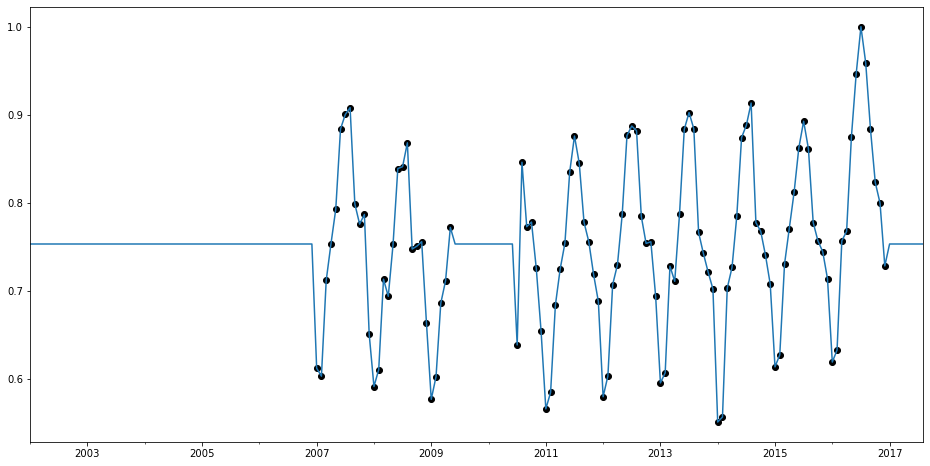

In [20]:
idx = 26
mean_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [21]:
%%time
val_df = generate_validation_frame(train_df, holdout_pct=holdout_pct)
mean_holdout_df = mean_full(val_df)

Wall time: 1.01 s


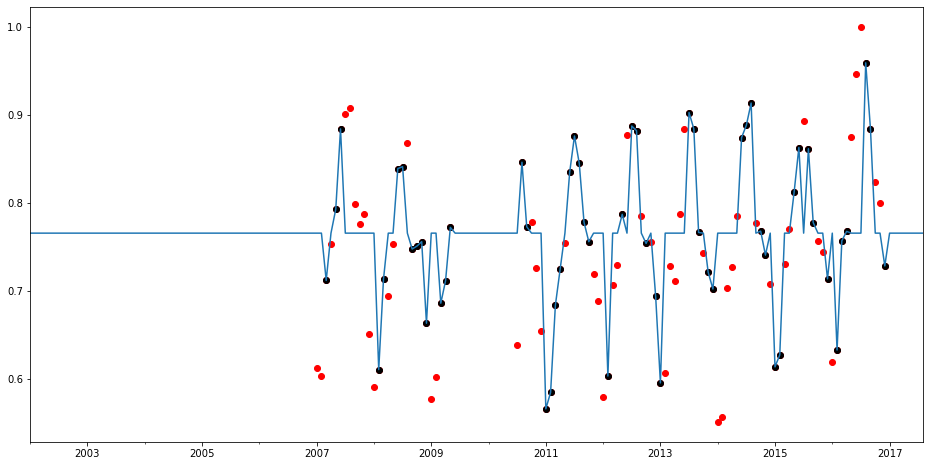

In [22]:
mean_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [23]:
validation_scores = {}

In [24]:
%%time
score = evaluate_imputation_method(train_df, mean_full)
validation_scores['mean'] = score

Wall time: 6.98 s


In [25]:
for key, val in validation_scores['mean'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.456
mean_absolute_error: 3.017


## Fill with Seasonal Mean

Next, a seasonal approach was taken to filling with the mean. Since the data exhibits a strong annual seasonality, the values were split into 12 groups, one for each month. For example, the January group contained the traffic volumes for January 2002, January 2003, January 2004, etc. Within each group, values were imputed by the mean of that month's entries.

In [26]:
def seasonal_split(df):
    df = df.copy()
    
    # Split the dataframe into subframes with one frame for each month
    index_frequencies = [ 'A-JAN', 'A-FEB', 'A-MAR', 'A-APR', 'A-MAY', 'A-JUN', 'A-JUL', 'A-AUG', 
                     'A-SEP', 'A-OCT', 'A-NOV', 'A-DEC']
    date_ranges = [ pd.date_range(start=df.first_valid_index(), end=df.last_valid_index(), freq=freq) \
                   for freq in index_frequencies]
    
    subframes = [ df.loc[date_range] for date_range in date_ranges ]
    
    return subframes

In [27]:
def mean_seasonal(df):
    subframes = seasonal_split(df)
    
    recovered_frames = []
    for sub_df in subframes:
        recovered = mean_full(sub_df)
        recovered_frames.append(recovered)
        
    recovered_df = pd.concat(recovered_frames)
    recovered_df.sort_index(inplace=True)

    return recovered_df

In [28]:
%%time
mean_seasonal_df = mean_seasonal(train_df)

Wall time: 138 ms


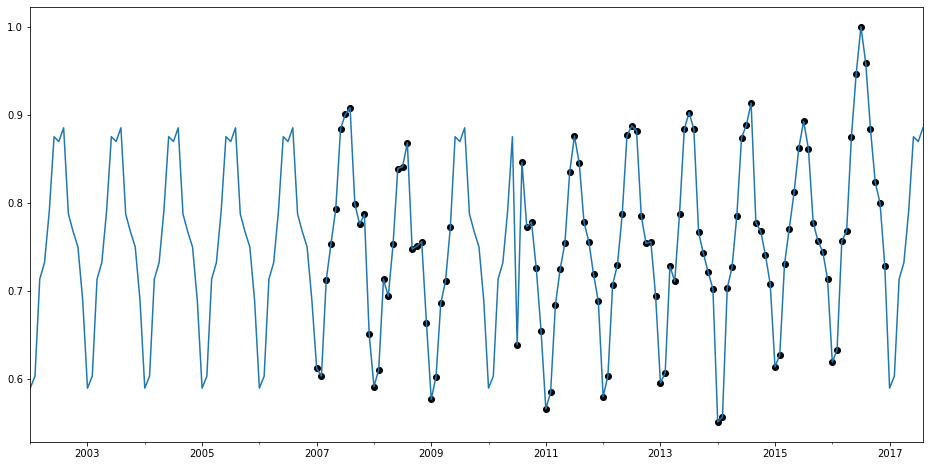

In [29]:
mean_seasonal_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [30]:
%%time
mean_seasonal_holdout_df = mean_seasonal(val_df)

Wall time: 133 ms


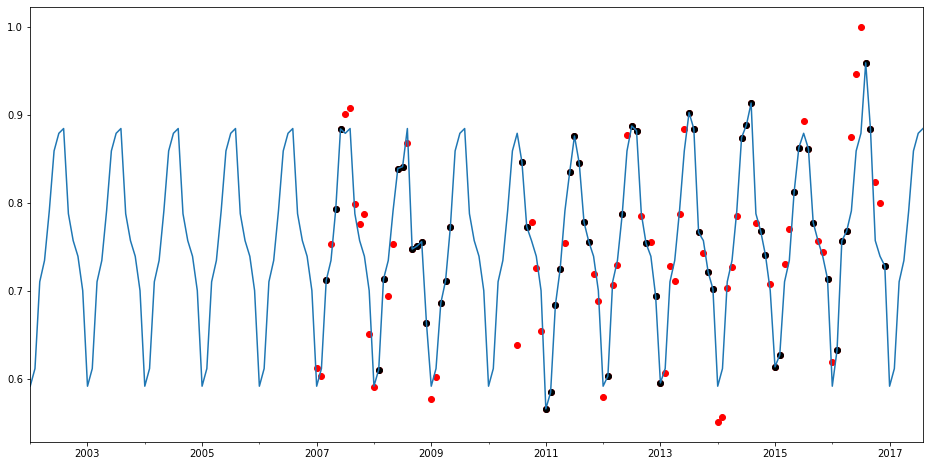

In [31]:
mean_seasonal_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [32]:
%%time
score = evaluate_imputation_method(train_df, mean_seasonal)
validation_scores['seasonal_mean'] = score

Wall time: 5.95 s


In [33]:
for key, val in validation_scores['seasonal_mean'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.200
mean_absolute_error: 1.625


## CDRec

The next imputation techniques attempt to utilize the correlation between individual time series. The particular method used was a particular Centroid Decomposition (CD) algorithm named CDRec by its developers (Khayati, Cudré-Mauroux & Böhlen). This method is described in the article [Scalable recovery of missing blocks in time series with high and low cross-correlations](https://link.springer.com/article/10.1007/s10115-019-01421-7). An implementation is maintained on Github by the [first author](https://github.com/eXascaleInfolab/cdrec).

The algorithm is slightly modified to prevent negative values by replacing any negative values with zero.

In [34]:
# CDRec is available on Github at https://github.com/eXascaleInfolab/cdrec
# The file run here is identical to the one found in commit 2083ee9 on Github except the function main and its execution
# were removed as unnecessary.
%run recovery.py

In [35]:
def cdrec_full(df, truncation=1, maxIterations=100, threshold=1E-6):
    df = df.copy()
    # If the time series begins with a null value, the CDRec method puts an impossibly large value in the first entry.
    # Add an initial null value to every time series that will be dropped in order to account for this.
    df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
    df.sort_index(inplace=True)
    
    # Apply the CDRec algorithm
    recovered = centroid_recovery(df, truncation=truncation, maxIterations=maxIterations, threshold=threshold)
    recovered_df = pd.DataFrame(recovered)
    recovered_df.columns = df.columns
    recovered_df.index = df.index
    
    # There's a possibility that the imputed values drop below 0. Since this is physically impossible, replace negative
    # values with 0
    recovered_df[recovered_df < 0] = 0
    
    # Drop the initial null values
    recovered_df = recovered_df['2002-01-31':]

    return recovered_df

In [36]:
%%time
cdrec_df = cdrec_full(train_df)

C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan


Wall time: 2.83 s


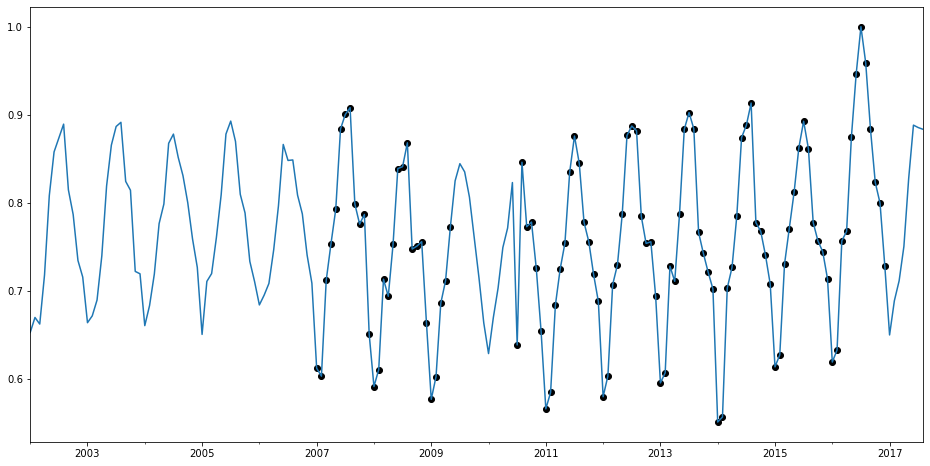

In [37]:
cdrec_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [38]:
%%time
cdrec_holdout_df = cdrec_full(val_df)

C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan


Wall time: 3.07 s


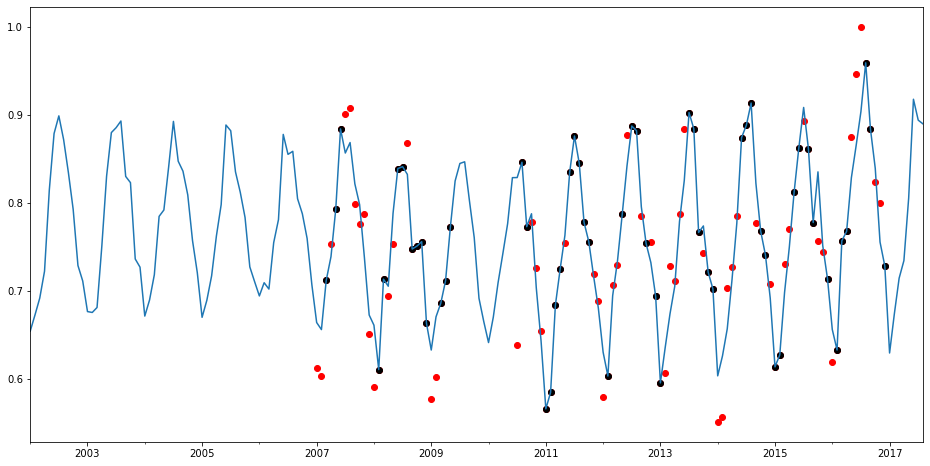

In [39]:
cdrec_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [40]:
%%time
score = evaluate_imputation_method(train_df, cdrec_full)
validation_scores['cdrec'] = score

C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/42

Wall time: 24.7 s


In [41]:
for key, val in validation_scores['cdrec'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.274
mean_absolute_error: 2.128


## CDRec - Seasonal

The imputation plotted above makes it appear as if the full range of seasonal fluctuation is not being captured. The same seasonal modification used in the seasonal mean is attempted here. The idea is that by focusing on the monthly subframes, the seasonality may be reproduced.

In [42]:
def cdrec_monthly(df, truncation=1, maxIterations=100, threshold=1E-6):
    df = df.copy()
    
    # Split the dataframe into subframes with one frame for each month
    index_frequencies = [ 'A-JAN', 'A-FEB', 'A-MAR', 'A-APR', 'A-MAY', 'A-JUN', 'A-JUL', 'A-AUG', 
                     'A-SEP', 'A-OCT', 'A-NOV', 'A-DEC']
    date_ranges = [ pd.date_range(start=df.first_valid_index(), end=df.last_valid_index(), freq=freq) \
                   for freq in index_frequencies]
    
    subframes = [ df.loc[date_range] for date_range in date_ranges ]
    
    recovered_frames = []
    for sub_df in subframes:
        recovered = cdrec_full(sub_df, truncation=truncation, maxIterations=maxIterations, threshold=threshold)
        recovered_frames.append(recovered)
        
    recovered_df = pd.concat(recovered_frames)
    recovered_df.sort_index(inplace=True)

    return recovered_df

In [43]:
%%time
cdrec_seasonal_df = cdrec_monthly(train_df)

C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan


Wall time: 3.57 s


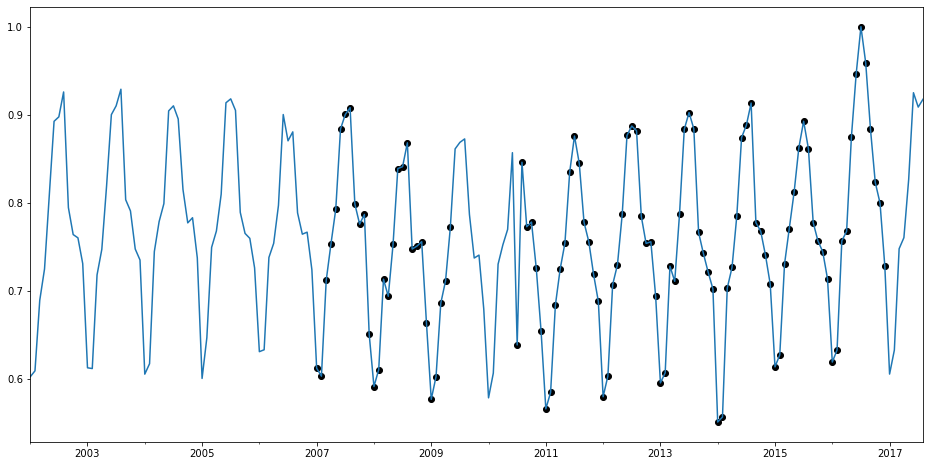

In [44]:
cdrec_seasonal_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [45]:
%%time
cdrec_seasonal_holdout_df = cdrec_monthly(val_df)

C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan


Wall time: 3.48 s


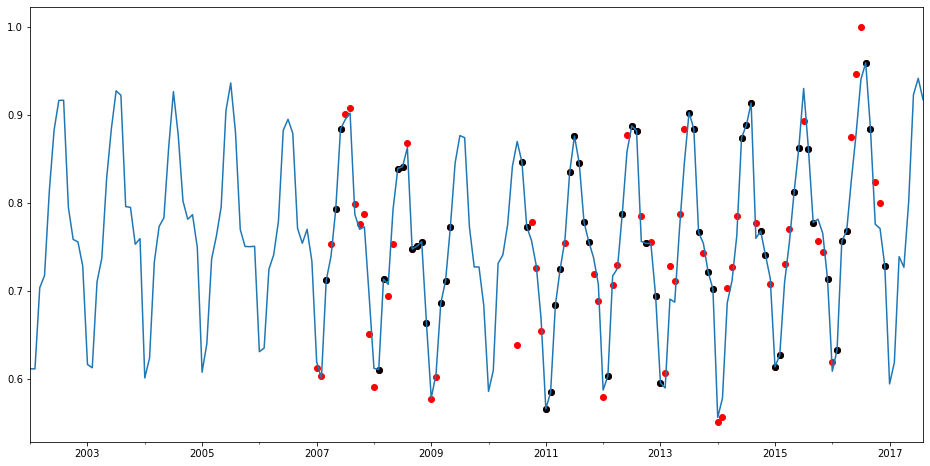

In [46]:
cdrec_seasonal_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [47]:
%%time
score = evaluate_imputation_method(train_df, cdrec_monthly)
validation_scores['seasonal_cdrec'] = score

C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/42

Wall time: 30.6 s


In [48]:
for key, val in validation_scores['seasonal_cdrec'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.180
mean_absolute_error: 1.464


## Prophet

Facebook Prophet can be used for imputation, so that is attempted here. Initially, the linear algorithm is used with a correction of changing any calculated negative values to zero. Prophet is independently applied to each column.

In [49]:
# Prophet expects a data frame with 2 columns. One column 'ds' with the time stamps and one column 'y' with the data.
def produce_prophet_series(y, logistic=False):
    if logistic:
        df = pd.DataFrame({'ds': y.index, 'y':y})
        df['cap'] = 10
        df['floor'] = 0   
    else:
        df = pd.DataFrame({'ds': y.index, 'y':y})
    return df

In [53]:
def prophet(df, logistic=False):
    df = df.copy()
    predicted_df = pd.DataFrame(index=df.index) 
    for col in df:
        prop = produce_prophet_series(df[col], logistic=logistic)
        if logistic:
            model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, growth='logistic')
        else:
            model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
        model.fit(prop)
        # Since future forecasts aren't desired, set periods = 0, which will produce a model on the timeframe covered by df
        prediction_frame = model.make_future_dataframe(periods=0, freq='M')
        if logistic:
            prediction_frame['cap'] = 10
            prediction_frame['floor'] = 0
        prediction = model.predict(prediction_frame)
        yhat = prediction['yhat']
        yhat.index = predicted_df.index
        predicted_df[col] = yhat
    
    # Make sure that any negative values are trimmed to 0
    predicted_df[predicted_df < 0] = 0
    # At this point, Prophet is only being used for imputing, so only the null values from df should be different from df
    predicted_df[df.notna()] = df
    return predicted_df

In [54]:
%%time
prophet_df = prophet(train_df)

INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


Wall time: 2min 52s


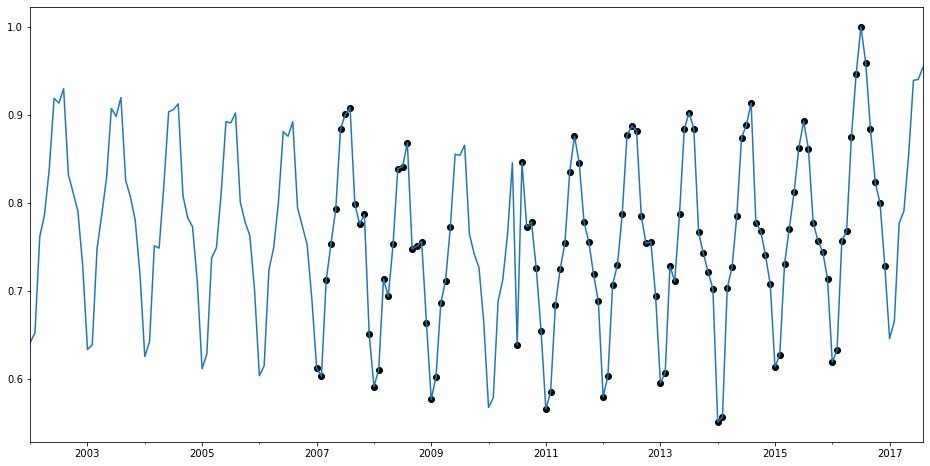

In [52]:
prophet_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [55]:
%%time
prophet_holdout_df = prophet(val_df)

INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


Wall time: 5min 23s


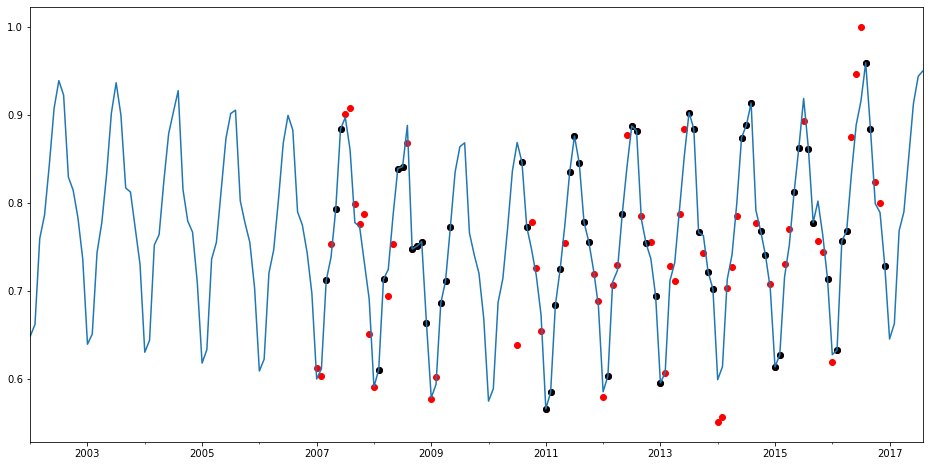

In [56]:
prophet_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [57]:
%%time
score = evaluate_imputation_method(train_df, prophet)
validation_scores['prophet'] = score

INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints 

Wall time: 25min 21s


In [58]:
for key, val in validation_scores['prophet'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 1.681
mean_absolute_error: 2.692


## Prophet with Logistic Floor

Finally, the logistic algorithm for Prophet is used along with a floor of 0.

In [59]:
%%time
prophet_logistic_df = prophet(train_df, logistic=True)

INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


Wall time: 3min 22s


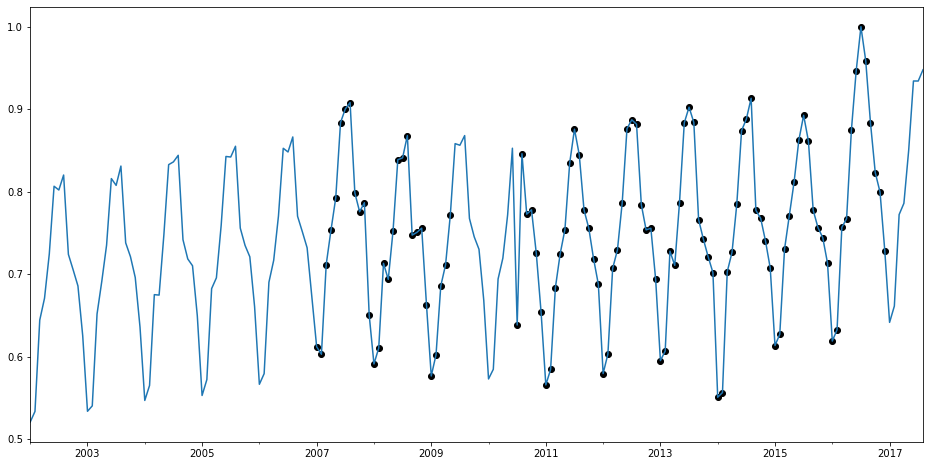

In [60]:
prophet_logistic_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [61]:
%%time
prophet_logistic_holdout_df = prophet(val_df, logistic=True)

INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


Wall time: 7min 8s


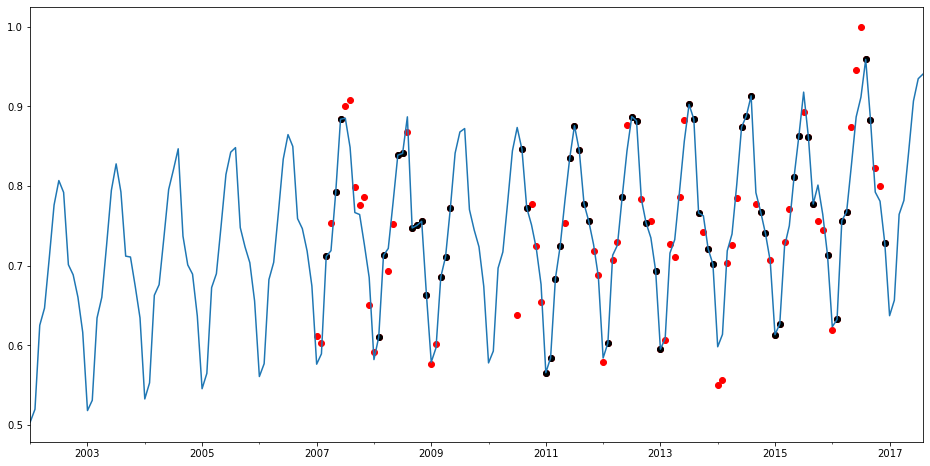

In [62]:
prophet_logistic_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [63]:
%%time
score = evaluate_imputation_method(train_df, lambda x: prophet(x, logistic=True))
validation_scores['logistic_prophet'] = score

INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints 

Wall time: 35min 21s


In [64]:
for key, val in validation_scores['logistic_prophet'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 2.805
mean_absolute_error: 2.585


# Evaluation

In [65]:
mse_scores = { key: value['mean_squared_error'] for key, value in validation_scores.items() }
mae_scores = { key: value['mean_absolute_error'] for key, value in validation_scores.items() }

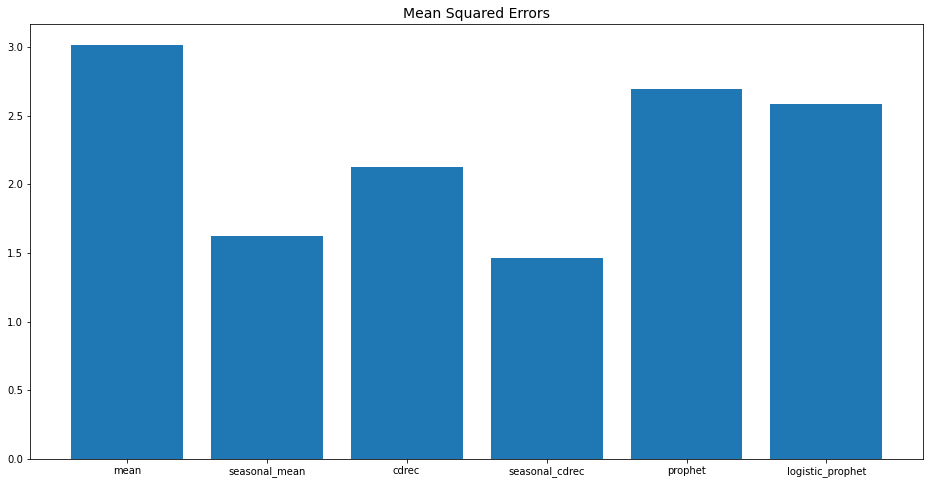

In [72]:
x_axis = list(mse_scores.keys())
fig, ax = plt.subplots(1, 1, figsize=(16,8), sharex=True);
ax.bar(x=x_axis, height=mae_scores.values());
plt.title('Mean Squared Errors', fontsize=14);

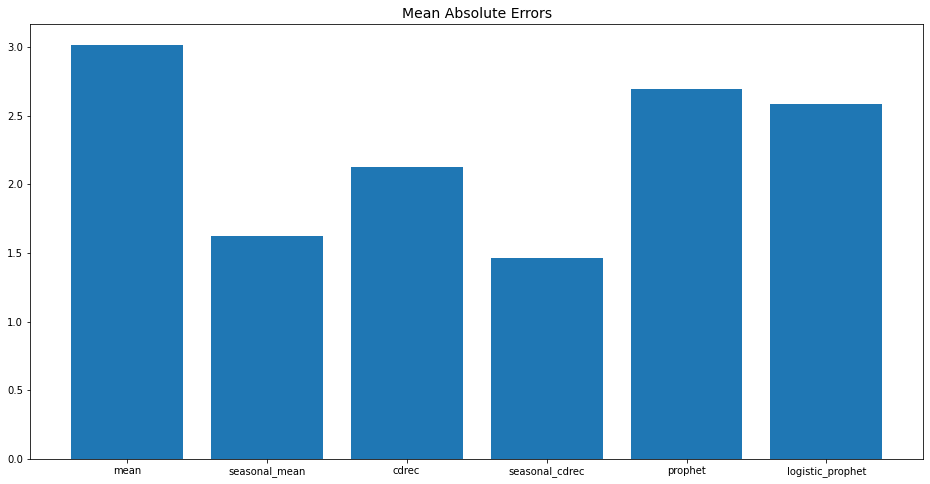

In [67]:
x_axis = list(mae_scores.keys())
fig, ax = plt.subplots(1, 1, figsize=(16,8), sharex=True);
ax.bar(x=x_axis, height=mae_scores.values());
plt.title('Mean Absolute Errors', fontsize=14);

In [68]:
print(f"The best mean squared error score is {min(mse_scores, key=mse_scores.get)} " \
      + f"with a value of {min(mse_scores.values()):0.3f}")
print(f"The best mean absolute error score is {min(mae_scores, key=mae_scores.get)} " \
      + f"with a value of {min(mae_scores.values()):0.3f}")

The best mean squared error score is seasonal_cdrec with a value of 0.180
The best mean absolute error score is seasonal_cdrec with a value of 1.464


The seasonal variation of CDRec outperforms each other method.

In [78]:
imputed_train_df = cdrec_monthly(train_df)
imputed_train_df *= train_maxs
imputed_test_df = cdrec_monthly(test_df)
imputed_test_df *= train_maxs
full_df = df.copy()
full_df /= train_maxs
imputed_full_df = cdrec_monthly(full_df)

C:\Users\wodar\AppData\Local\Temp/ipykernel_28152/4229536107.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan


In [79]:
imputed_train_file_name = 'data/imputed_train.pkl'
imputed_train_df.to_pickle(imputed_train_file_name)
imputed_test_file_name = 'data/imputed_test.pkl'
imputed_test_df.to_pickle(imputed_test_file_name)
imputed_full_file_name = 'data/imputed_full.pkl'
imputed_full_df.to_pickle(imputed_full_file_name)

In [80]:
nonimputed_train_file_name = 'data/nonimputed_train.pkl'
train_df *= train_maxs
train_df.to_pickle(nonimputed_train_file_name)
nonimputed_test_file_name = 'data/nonimputed_test.pkl'
test_df *= train_maxs
test_df.to_pickle(nonimputed_test_file_name)

In [81]:
nonimputed_full_file_name = 'data/nonimputed_full.pkl'
df.to_pickle(nonimputed_full_file_name)